# Validation on low and high confidence EV datasets

This notebook includes studies: 

High confidence (HC)

- Karimi, N., Cvjetkovic, A., Jang, S.C. et al. Detailed analysis of the plasma extracellular vesicle proteome after separation from lipoproteins. Cell. Mol. Life Sci. 75, 2873–2886 (2018). https://doi.org/10.1007/s00018-018-2773-4

- Dhondt, B., Geeurickx, E., Tulkens, J., Van Deun, J., Vergauwen, G., Lippens, L., Miinalainen, I., Rappu, P., Heino, J., Ost, P., Lumen, N., De Wever, O. and Hendrix, A. (2020), Unravelling the proteomic landscape of extracellular vesicles in prostate cancer by density-based fractionation of urine. Journal of Extracellular Vesicles, 9: 1736935. https://doi.org/10.1080/20013078.2020.1736935

- Martínez-Greene, J. A., Hernández-Ortega, K., Quiroz-Baez, R., Resendis-Antonio, O., Pichardo-Casas, I., Sinclair, D. A., Budnik, B., Hidalgo-Miranda, A., Uribe-Querol, E., Ramos-Godínez, M. P., & Martínez-Martínez, E. (2021). Quantitative proteomic analysis of extracellular vesicle subgroups isolated by an optimized method combining polymer-based precipitation and size exclusion chromatography. J. Extracell. Vesicles, 10, e12087. https://doi.org/10.1002/jev2.12087

Low confidence (LC) are EV proteins detected in all EV studies before 2010.
 
Output datasets:
- validation_all.csv
- validation_nonoverlapping.csv

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted, venn3, venn3_circles

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Define paths

In [2]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'

## Import data sets

### Feature datasets

In [3]:
df_all = pd.read_csv(Data_path + "/curated/features_human_proteome.csv")
df_MS_iso = pd.read_csv(Data_path + "/training/training_data_MS_iso_filter.csv")

df_MS_iso_EV = df_MS_iso[df_MS_iso["EV"] == 1]

### Low confidence EV protein set

In [4]:
low_confidence_list = []
with open(Data_path + "/curated/Low_confidence_EV_proteins.txt") as f:
    lines = f.readlines()
    for line in lines:
        low_confidence_list.append(line.strip())
print("Number of EV proteins in low confidence set:", len(low_confidence_list))

low_confidence_non_overlapping = set(low_confidence_list) - set(df_MS_iso_EV['id'])
print("Number of non-overlapping EV proteins in low confidence set:", len(low_confidence_non_overlapping))

Number of EV proteins in low confidence set: 9988
Number of non-overlapping EV proteins in low confidence set: 4974


### High confidence EV protein set

In [5]:
high_confidence_list = []
with open(Data_path + "/curated/High_confidence_EV_proteins.txt") as f:
    lines = f.readlines()
    for line in lines:
        high_confidence_list.append(line.strip())
print("Number of EV proteins in high confidence set:", len(high_confidence_list))

high_confidence_non_overlapping = set(high_confidence_list) - set(df_MS_iso_EV['id'])
print("Number of non-overlapping EV proteins in high confidence set:", len(high_confidence_non_overlapping))

Number of EV proteins in high confidence set: 3243
Number of non-overlapping EV proteins in high confidence set: 594


## Create comparison dataset

In [6]:
# select overlapping proteins
df_high_confidence = df_all[df_all['id'].isin(high_confidence_list)]
df_high_confidence.drop(['fasta_sequence'], axis=1, inplace=True)

# mark high confidence EV proteins with different label
df_high_confidence["EV"] = 2

In [7]:
# select overlapping proteins
df_low_confidence = df_all[df_all['id'].isin(low_confidence_list)]
df_low_confidence.drop(['fasta_sequence'], axis=1, inplace=True)

# mark high confidence EV proteins with different label
df_low_confidence["EV"] = 3

In [8]:
df_comparison = pd.concat([df_MS_iso, df_high_confidence, df_low_confidence])
df_comparison["EV"].value_counts().sort_index()

0    10290
1     5965
2     3222
3     9908
Name: EV, dtype: int64

## Statistical significance testing

In [9]:
continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 
    'thsa_netsurfp2', 'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 
    'E_exposed', 'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 
    'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 
    'Y_exposed', 'Probability_solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 
    'Gravy', 'Isoelectric_point', 'Charge_at_7', 'Charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

categorical = ['HSP', 'PTM_Uniprot', 'Citrullination_Uniprot', 'GPI-anchor_Uniprot', 'Nitration_Uniprot', 
    'Prenylation_Uniprot', 'ISGylation_Uniprot', 'NEDDylation_Uniprot', 'Acetylation_all', 'Glycosylation_all', 
    'Methylation_all', 'Myristoylation_all', 'Nitrosylation_all', 'Palmitoylation_all', 'Phosphorylation_all', 
    'SUMOylation_all', 'Ubiquitination_all', 'PTM_MSD', 'Phosphorylation_MSD', 'Glycosylation_MSD', 
    'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD',  'Palmitoylation_MSD', 'Methylation_MSD', 
    'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM', 'transmembrane', 'TMHMM']

In [10]:
def calculate_p_value_continuous(EV_df, non_EV_df, feature):
    
    stat, p = mannwhitneyu(EV_df[feature], non_EV_df[feature]) # function return statistic and p-value
    return p


def calculate_p_value_categorical(EV_df, non_EV_df, feature):
    
    # get counts for each category
    A = sum(EV_df[feature]) # EV & positive
    B = len(EV_df[feature]) - sum(EV_df[feature]) # EV & negative
    C = sum(non_EV_df[feature]) # no EV & positive
    D = len(non_EV_df[feature]) - sum(non_EV_df[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B], [C, D]])
    odds, p = fisher_exact(table, alternative="two-sided") # function return odds ratio and p-value
    return p


def test_statistical_significance(EV_df, non_EV_df):

    p_vals = pd.Series(index=continuous+categorical, dtype="float64", name="P_value")

    for feature in continuous:
        p = calculate_p_value_continuous(EV_df, non_EV_df, feature)
        p_vals.loc[feature] = p 
        
    for feature in categorical:
        p = calculate_p_value_categorical(EV_df, non_EV_df, feature)
        p_vals.loc[feature] = p 
        
    # calculate adjusted p-value (FDR correction)
    rejected, p_vals_adj = fdrcorrection(p_vals)
    p_vals_adj = pd.Series(data=p_vals_adj, index=continuous+categorical, name="P_value_adjusted")   
    p_vals = pd.concat([p_vals, p_vals_adj], axis=1)
        
    return p_vals


def print_p_val(p_val):
    
    if p_val < 0.0001:
        return "<0.0001"
    else:
        return "%.4f" % p_val
    

def annot_stat(star, x1, x2, y, h, col='k', ax=None):
    ax = plt.gca() if ax is None else ax
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, star, ha='center', va='bottom', color=col)

In [11]:
EV_0 = df_comparison[df_comparison["EV"] == 0]
EV_1 = df_comparison[df_comparison["EV"] == 1]
EV_2 = df_comparison[df_comparison["EV"] == 2]
EV_3 = df_comparison[df_comparison["EV"] == 3]

In [12]:
# compare non-EV and EV proteins (from discovery dataset)
EV_0_1 = test_statistical_significance(EV_0, EV_1)
# compare non-EV and high confidence EV proteins
EV_0_2 = test_statistical_significance(EV_0, EV_2)
# compare non-EV and low confidence EV proteins
EV_0_3 = test_statistical_significance(EV_0, EV_3)

## Data visualization

### Violin plots (continuous features)

In [13]:
# figure settings
sns.set(style=("ticks"), font_scale=1.2)
x1, x2, x3, x4 = 0, 1, 2, 3 
my_pal = {2: "lightcyan", 1: "cornflowerblue", 3:"orange", 0: "darkblue"}
labels = ["HC EV", "EV", "LC EV", "non-EV"]

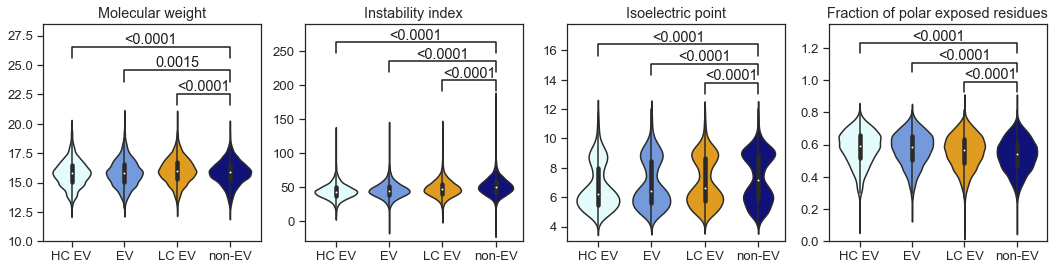

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(18, 4))

feature="molecular_weight"
sns.violinplot(x="EV", y=feature, data=df_comparison, ax=ax1, order=[2, 1, 3, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Molecular weight", xticklabels=(labels), ylim=(10, 28.5))
y, h, col = df_comparison[feature].max() + 0.8, 1, 'k'
ax1.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x3+x4)*.5, y+h, print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 2.8, 1, 'k'
ax1.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x2+x4)*.5, y+h, print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 4.8, 1, 'k'
ax1.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x4)*.5, y+h, print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature="Instability_index"
sns.violinplot(x="EV", y=feature, data=df_comparison, ax=ax2, order=[2, 1, 3, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Instability index", xticklabels=(labels), ylim=(-30, 290))
y, h, col = df_comparison[feature].max() + 7, 15, 'k'
ax2.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x3+x4)*.5, y+h, print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 35, 15, 'k'
ax2.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x2+x4)*.5, y+h, print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 63, 15, 'k'
ax2.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x4)*.5, y+h, print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature="Isoelectric_point"
sns.violinplot(x="EV", y=feature, data=df_comparison, ax=ax3, order=[2, 1, 3, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Isoelectric point", xticklabels=(labels), ylim=(3, 17.8))
y, h, col = df_comparison[feature].max() + 1, 0.8, 'k'
ax3.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x3+x4)*.5, y+h, print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 2.3, 0.8, 'k'
ax3.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x2+x4)*.5, y+h, print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 3.6, 0.8, 'k'
ax3.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x4)*.5, y+h, print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature="Polar_exposed"
sns.violinplot(x="EV", y=feature, data=df_comparison, ax=ax4, order=[2, 1, 3, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Fraction of polar exposed residues", xticklabels=(labels), ylim=(0, 1.35))
y, h, col = df_comparison[feature].max() + 0.05, 0.06, 'k'
ax4.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x3+x4)*.5, y+h, print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.17, 0.06, 'k'
ax4.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x2+x4)*.5, y+h, print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.29, 0.06, 'k'
ax4.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x4)*.5, y+h, print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

plt.show()

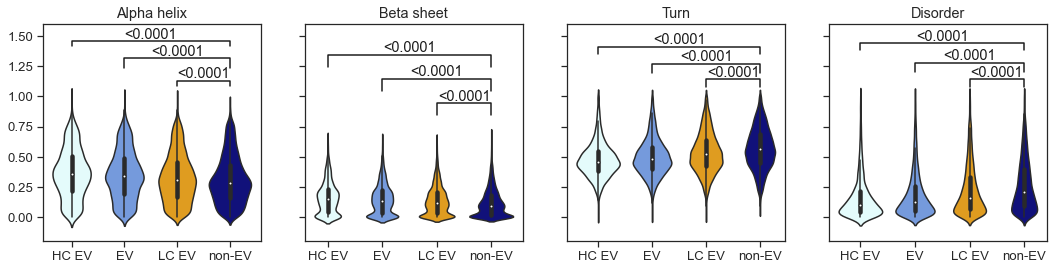

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((-0.2, 1.6))

feature="helix"
sns.violinplot(x="EV", y=feature, data=df_comparison, ax=ax1, order=[2, 1, 3, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Alpha helix", xticklabels=(labels))
y, h, col = df_comparison[feature].max() + 0.1, 0.04, 'k'
ax1.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x3+x4)*.5, y+h, print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.25, 0.08, 'k'
ax1.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x2+x4)*.5, y+h, print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.43, 0.04, 'k'
ax1.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x4)*.5, y+h, print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature="sheet"
sns.violinplot(x="EV", y=feature, data=df_comparison, ax=ax2, order=[2, 1, 3, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Beta sheet", xticklabels=(labels))
y, h, col = df_comparison[feature].max() + 0.15, 0.1, 'k'
ax2.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x3+x4)*.5, y+h, print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.35, 0.1, 'k'
ax2.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x2+x4)*.5, y+h, print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.55, 0.1, 'k'
ax2.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x4)*.5, y+h, print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature="turn"
sns.violinplot(x="EV", y=feature, data=df_comparison, ax=ax3, order=[2, 1, 3, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Turn", xticklabels=(labels))
y, h, col = df_comparison[feature].max() + 0.08, 0.06, 'k'
ax3.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x3+x4)*.5, y+h, print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.19, 0.08, 'k'
ax3.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x2+x4)*.5, y+h, print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.35, 0.06, 'k'
ax3.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x4)*.5, y+h, print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature="disorder"
sns.violinplot(x="EV", y=feature, data=df_comparison, ax=ax4, order=[2, 1, 3, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Disorder", xticklabels=(labels));
y, h, col = df_comparison[feature].max() + 0.08, 0.06, 'k'
ax4.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x3+x4)*.5, y+h, print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.2, 0.08, 'k'
ax4.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x2+x4)*.5, y+h, print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_comparison[feature].max() + 0.38, 0.06, 'k'
ax4.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x4)*.5, y+h, print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

plt.show()

### Bar plots (categorical features)

In [16]:
# figure settings
sns.set(style=("ticks"), font_scale=1.2)
x1, x2, x3, x4 = 0, 1, 2, 3 
my_pal = {2: "lightcyan", 1: "cornflowerblue", 3:"orange", 0: "darkblue"}
labels = ["HC EV", "EV", "LC EV",  "non-EV"]

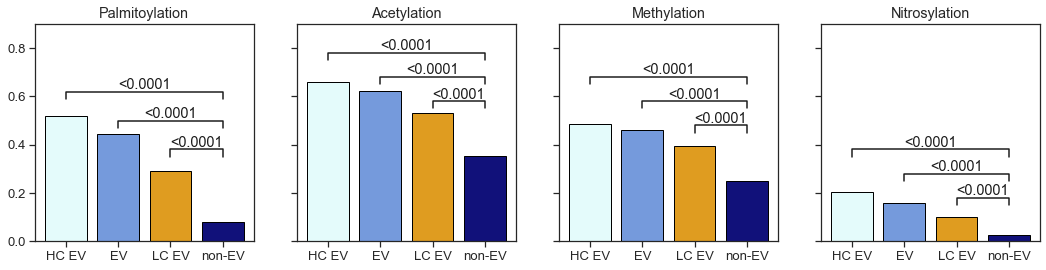

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((0,0.9))

feature="Palmitoylation_all"
sns.barplot(x="EV", y=feature, data=df_comparison, ax=ax1, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax1.set(ylabel=None, xlabel=None, title="Palmitoylation", xticklabels=(labels))
annot_stat(print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), 3, 2, 0.35, 0.03, ax=ax1)
annot_stat(print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), 1, 3, 0.47, 0.03, ax=ax1)
annot_stat(print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), 0, 3, 0.59, 0.03, ax=ax1)

feature="Acetylation_all"
sns.barplot(x="EV", y=feature, data=df_comparison, ax=ax2, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax2.set(ylabel=None, xlabel=None, title="Acetylation", xticklabels=(labels))
annot_stat(print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), 3, 2, 0.55, 0.03, ax=ax2)
annot_stat(print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), 1, 3, 0.65, 0.03, ax=ax2)
annot_stat(print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), 0, 3, 0.75, 0.03, ax=ax2)

feature="Methylation_all"
sns.barplot(x="EV", y=feature, data=df_comparison, ax=ax3, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax3.set(ylabel=None, xlabel=None, title="Methylation", xticklabels=(labels));
annot_stat(print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), 3, 2, 0.45, 0.03, ax=ax3)
annot_stat(print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), 1, 3, 0.55, 0.03, ax=ax3)
annot_stat(print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), 0, 3, 0.65, 0.03, ax=ax3)

feature="Nitrosylation_all"
sns.barplot(x="EV", y=feature, data=df_comparison, ax=ax4, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax4.set(ylabel=None, xlabel=None, title="Nitrosylation", xticklabels=(labels))
annot_stat(print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), 3, 2, 0.15, 0.03, ax=ax4)
annot_stat(print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), 1, 3, 0.25, 0.03, ax=ax4)
annot_stat(print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), 0, 3, 0.35, 0.03, ax=ax4)

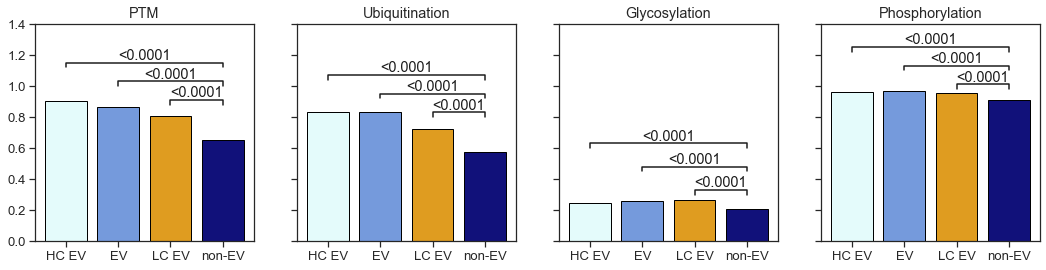

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((0,1.4))

feature="PTM_Uniprot"
sns.barplot(x="EV", y=feature, data=df_comparison, ax=ax1, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax1.set(ylabel=None, xlabel=None, title="PTM", xticklabels=(labels))
annot_stat(print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), 3, 2, 0.88, 0.03, ax=ax1)
annot_stat(print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), 1, 3, 1, 0.03, ax=ax1)
annot_stat(print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), 0, 3, 1.12, 0.03, ax=ax1)

feature="Ubiquitination_all"
sns.barplot(x="EV", y=feature, data=df_comparison, ax=ax2, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax2.set(ylabel=None, xlabel=None, title="Ubiquitination", xticklabels=(labels))
annot_stat(print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), 3, 2, 0.8, 0.03, ax=ax2)
annot_stat(print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), 1, 3, 0.92, 0.03, ax=ax2)
annot_stat(print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), 0, 3, 1.04, 0.03, ax=ax2)

feature="Glycosylation_all"
sns.barplot(x="EV", y="Glycosylation_all", data=df_comparison, ax=ax3, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax3.set(ylabel=None, xlabel=None, title="Glycosylation", xticklabels=(labels));
annot_stat(print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), 3, 2, 0.3, 0.03, ax=ax3)
annot_stat(print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), 1, 3, 0.45, 0.03, ax=ax3)
annot_stat(print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), 0, 3, 0.6, 0.03, ax=ax3)

feature="Phosphorylation_all"
sns.barplot(x="EV", y=feature, data=df_comparison, ax=ax4, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax4.set(ylabel=None, xlabel=None, title="Phosphorylation", xticklabels=(labels))
annot_stat(print_p_val(EV_0_3.loc[feature, "P_value_adjusted"]), 3, 2, 0.98, 0.03, ax=ax4)
annot_stat(print_p_val(EV_0_1.loc[feature, "P_value_adjusted"]), 1, 3, 1.1, 0.03, ax=ax4)
annot_stat(print_p_val(EV_0_2.loc[feature, "P_value_adjusted"]), 0, 3, 1.22, 0.03, ax=ax4)